In [1]:
# 환경 설정
from mlwpy import *
%matplotlib inline

diabetes = datasets.load_diabetes()

tts = skms.train_test_split(diabetes.data,
                            diabetes.target, 
                            test_size=.25,
                            random_state=42)

(diabetes_train_ftrs, diabetes_test_ftrs, 
 diabetes_train_tgt,  diabetes_test_tgt) = tts

In [2]:
baseline = dummy.DummyRegressor(strategy='median')

In [3]:
strategies = ['constant', 'quantile', 'mean', 'median', ]
baseline_args = [{"strategy":s} for s in strategies]

# 상수와 분위수를 위한 추가적인 인수
baseline_args[0]['constant'] = 50.0
baseline_args[1]['quantile'] =  0.75

# 5장과 비슷하지만 여기서는 리스트 컴프리헨션을 사용합니다.
# 딕셔너리를 인수로 전달합니다.
def do_one(**args):
    baseline = dummy.DummyRegressor(**args)
    baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
    base_preds = baseline.predict(diabetes_test_ftrs)
    return metrics.mean_squared_error(base_preds, diabetes_test_tgt)

# 리스트 컴프리헨션으로 모든 결과를 종합합니다.
mses = [do_one(**bla) for bla in baseline_args]

display(pd.DataFrame({'mse':mses}, 
                     index=strategies))

,mse
constant,"14,657.6847"
quantile,"10,216.3874"
mean,"5,607.1979"
median,"5,542.2252"


In [4]:
def rms_error(actual, predicted):
    '평균 제곱근 편차 함수(rmse)'
    # 값이 적을수록 좋습니다 (a < b는 a가 더 좋다는 것을 의미합니다). 
    mse = metrics.mean_squared_error(actual, predicted)    
    return np.sqrt(mse)

def neg_rmse_score(actual, predicted):
    ' rmse에 기반한 점수 함수'
    # 높은 값이 더 좋습니다 (a < b는 b가 더 좋다는 것을 의미합니다). 
    return -rms_error(actual, predicted)

def neg_rmse_scorer(mod, ftrs, tgt_actual):
    '점수 인수에 적합한 rmse 점수 함수'
    tgt_pred = mod.predict(ftrs)
    return neg_rmse_score(tgt_actual, tgt_pred)


knn = neighbors.KNeighborsRegressor(n_neighbors=3)
skms.cross_val_score(knn, diabetes.data, diabetes.target, 
                     cv=skms.KFold(5, shuffle=True),
                     scoring=neg_rmse_scorer)

array([-58.0034, -64.9886, -63.1431, -61.8124, -57.6243])

In [5]:
lr = linear_model.LinearRegression()

# help(lr.score) # 목록을 전부 출력합니다.
print(lr.score.__doc__.splitlines()[0])

Returns the coefficient of determination R^2 of the prediction.


In [6]:
our_preds  = np.array([1,2,3])
mean_preds = np.array([2,2,2])
actual     = np.array([2,3,4])

sse_ours = np.sum(( our_preds - actual)**2)
sse_mean = np.sum((mean_preds - actual)**2)

In [7]:
r_2 = 1 - (sse_ours / sse_mean)
print("manual r2:{:5.2f}".format(r_2))

manual r2: 0.40


In [8]:
baseline = dummy.DummyRegressor(strategy='mean')

baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
base_preds = baseline.predict(diabetes_test_ftrs)

# r2는 비대칭적이므로 순서를 지켜야 합니다
base_r2_sklearn = metrics.r2_score(diabetes_test_tgt, base_preds)
print(base_r2_sklearn)

-0.014016723490579253


In [9]:
# sklearn으로 훈련 평균 모델의 테스트 예측을 수행합니다. 
base_errors    = base_preds - diabetes_test_tgt
sse_base_preds = np.dot(base_errors, base_errors)

# 훈련 평균을 계산해서 테스트 예측을 수행합니다.
train_mean_errors = np.mean(diabetes_train_tgt) - diabetes_test_tgt
sse_mean_train    = np.dot(train_mean_errors, train_mean_errors)

# 테스트-평균으로 테스트 예측을 수행합니다.
test_mean_errors = np.mean(diabetes_test_tgt) - diabetes_test_tgt
sse_mean_test    = np.dot(test_mean_errors, test_mean_errors)

print("sklearn train-mean model SSE(on test):", sse_base_preds)
print(" manual train-mean model SSE(on test):", sse_mean_train)
print(" manual test-mean  model SSE(on test):", sse_mean_test)

sklearn train-mean model SSE(on test): 622398.9703179051
 manual train-mean model SSE(on test): 622398.9703179051
 manual test-mean  model SSE(on test): 613795.5675675676


In [10]:
1 - (sse_base_preds / sse_mean_test)

-0.014016723490578809

In [11]:
print(base_r2_sklearn)
print(1 - (sse_base_preds / sse_mean_test))

-0.014016723490579253
-0.014016723490578809


In [12]:
# 
# 주의! 절대로 집에서 따라하지 마세요!
# sklearn R^2를 재현하기 위해서 *테스트* 세트를 이용해서 훈련을 합니다.
#

testbase = dummy.DummyRegressor(strategy='mean')
testbase.fit(diabetes_test_ftrs, diabetes_test_tgt)
testbase_preds = testbase.predict(diabetes_test_ftrs)
testbase_mse = metrics.mean_squared_error(testbase_preds, 
                                          diabetes_test_tgt)

models = [neighbors.KNeighborsRegressor(n_neighbors=3),
          linear_model.LinearRegression()]
results = co.defaultdict(dict)
for m in models:
    preds = (m.fit(diabetes_train_ftrs, diabetes_train_tgt)
              .predict(diabetes_test_ftrs))
             
    mse = metrics.mean_squared_error(preds, diabetes_test_tgt)
    r2  = metrics.r2_score(diabetes_test_tgt, preds)
    results[get_model_name(m)]['R^2'] = r2
    results[get_model_name(m)]['MSE'] = mse

print(testbase_mse)

df = pd.DataFrame(results).T
df['Norm_MSE'] = df['MSE'] / testbase_mse
df['1-R^2'] = 1-df['R^2']
display(df)

5529.689797906013


,R^2,MSE,Norm_MSE,1-R^2
KNeighborsRegressor,0.3722,"3,471.4194",0.6278,0.6278
LinearRegression,0.4849,"2,848.2953",0.5151,0.5151


In [13]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error
example,,,
0,4,3,1
1,2,5,-3
2,9,7,2


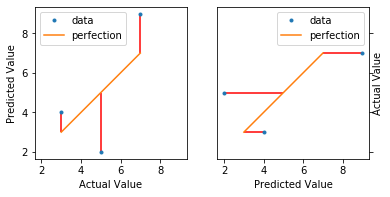

In [14]:
def regression_errors(figsize, predicted, actual, errors='all'):
    ''' figsize -> 플롯; 
        predicted/actual data -> DataFrame의 열 
        errors -> "all" 또는 인덱스 시퀀스''' 

    fig, axes = plt.subplots(1, 2, figsize=figsize, 
                             sharex=True, sharey=True)
    df = pd.DataFrame({'actual':actual, 
                       'predicted':predicted})

    for ax, (x,y) in zip(axes, it.permutations(['actual', 
                                                'predicted'])):
        # 데이터를 ‘.’로 표현합니다. 
        # 완벽한 데이터는 y=x 직선 상에 위치합니다.
        ax.plot(df[x], df[y], '.', label='data')
        ax.plot(df['actual'], df['actual'], '-', 
                label='perfection')
        ax.legend()

        ax.set_xlabel('{} Value'.format(x.capitalize()))
        ax.set_ylabel('{} Value'.format(y.capitalize()))
        ax.set_aspect('equal')

    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")
        
    # 전체 혹은 지정한 데이터와 직선을 막대로 연결합니다.
    if errors == 'all':
        errors = range(len(df))
    if errors:
        acts  = df.actual.iloc[errors]
        preds = df.predicted.iloc[errors]
        axes[0].vlines(acts, preds, acts, 'r')
        axes[1].hlines(acts, preds, acts, 'r')
        
    
regression_errors((6,3), ape_df.predicted, ape_df.actual)

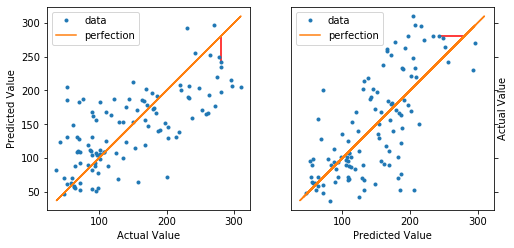

In [15]:
lr  = linear_model.LinearRegression()
preds = (lr.fit(diabetes_train_ftrs, diabetes_train_tgt)
           .predict(diabetes_test_ftrs))

regression_errors((8,4), preds, diabetes_test_tgt, errors=[-20]) 

In [16]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']
ape_df['resid'] = ape_df['actual'] - ape_df['predicted']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error,resid
example,,,,
0,4,3,1,-1
1,2,5,-3,3
2,9,7,2,-2


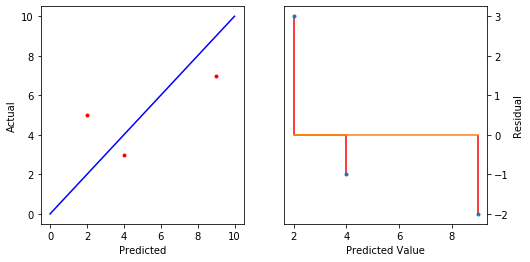

In [17]:
def regression_residuals(ax, predicted, actual, 
                         show_errors=None, right=False):
    ''' figsize -> 플롯;
        predicted/actual data -> 데이터프레임의 열
        errors -> “all” 혹은 인덱스 시퀀스''' 
    df = pd.DataFrame({'actual':actual, 
                       'predicted':predicted})
    df['error'] = df.actual - df.predicted
    ax.plot(df.predicted, df.error, '.')
    ax.plot(df.predicted, np.zeros_like(predicted), '-')
    
    if right:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('Residual')
    
    if show_errors == 'all':
        show_errors = range(len(df))
    if show_errors:
        preds = df.predicted.iloc[show_errors]
        errors = df.error.iloc[show_errors]
        ax.vlines(preds, 0, errors, 'r')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.plot(ape_df.predicted, ape_df.actual, 'r.', # 예측값 vs 실제값
         [0,10], [0,10], 'b-')                  # 완벽한 직선
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
regression_residuals(ax2, ape_df.predicted, ape_df.actual, 
                     'all', right=True) 

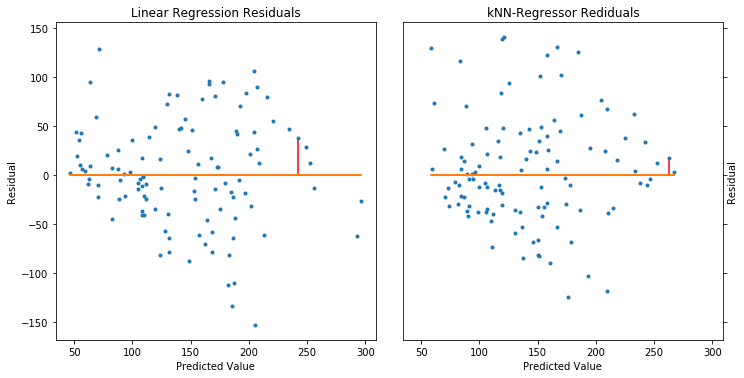

In [18]:
lr  = linear_model.LinearRegression()
knn = neighbors.KNeighborsRegressor()

models = [lr, knn]

fig, axes = plt.subplots(1, 2, figsize=(10,5), 
                         sharex=True, sharey=True)
fig.tight_layout()

for model, ax, on_right in zip(models, axes, [False, True]):
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
                  .predict(diabetes_test_ftrs))
    
    regression_residuals(ax, preds, diabetes_test_tgt, [-20], on_right)

axes[0].set_title('Linear Regression Residuals')
axes[1].set_title('kNN-Regressor Rediduals');

In [19]:
print(diabetes_test_tgt[-20])

280.0


,x,std-ized
mean,2.5000,0.0000
std,4.6706,1.0000


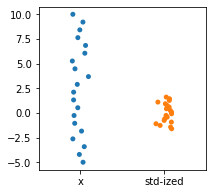

In [20]:
# 1D 표준화
# 데이터프레임에 일정한 간격의 값을 저장합니다. 
xs = np.linspace(-5, 10, 20)
df = pd.DataFrame(xs, columns=['x'])

# 중앙 (- mean)과 스케일 (/std)
df['std-ized'] = (df.x - df.x.mean()) / df.x.std()

# 원본 데이터와 새로운 데이터를 보여줍니다.
fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.stripplot(data=df)
display(df.describe().loc[['mean', 'std']])

In [21]:
# 2 1D 표준화
xs = np.linspace(-5, 10, 20)
ys = 3*xs + 2 + np.random.uniform(20, 40, 20)

df = pd.DataFrame({'x':xs, 'y':ys})
df_std_ized = (df - df.mean()) / df.std()

display(df_std_ized.describe().loc[['mean', 'std']])

,x,y
mean,0.0000,-0.0000
std,1.0000,1.0000


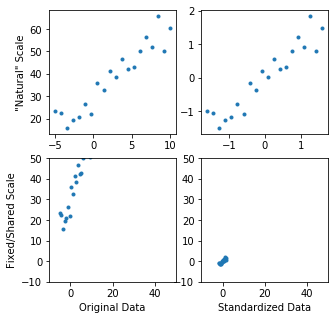

In [22]:
fig, ax = plt.subplots(2,2, figsize=(5,5))

ax[0,0].plot(df.x, df.y, '.')
ax[0,1].plot(df_std_ized.x, df_std_ized.y, '.')
ax[0,0].set_ylabel('"Natural" Scale')

ax[1,0].plot(df.x, df.y, '.')
ax[1,1].plot(df_std_ized.x, df_std_ized.y, '.')

ax[1,0].axis([-10, 50, -10, 50])
ax[1,1].axis([-10, 50, -10, 50])

ax[1,0].set_ylabel('Fixed/Shared Scale')
ax[1,0].set_xlabel('Original Data')
ax[1,1].set_xlabel('Standardized Data');

In [23]:
train_xs, test_xs = skms.train_test_split(xs.reshape(-1,1), test_size=.5)

scaler = skpre.StandardScaler()
scaler.fit(train_xs).transform(test_xs)

array([[ 0.5726],
       [ 0.9197],
       [ 1.9608],
       [ 0.7462],
       [ 1.7873],
       [-0.295 ],
       [ 1.6138],
       [ 1.4403],
       [-0.1215],
       [ 1.0932]])

In [24]:
(train_xs, test_xs,
 train_ys, test_ys)= skms.train_test_split(xs.reshape(-1,1), 
                                           ys.reshape(-1,1),
                                           test_size=.5)

scaler = skpre.StandardScaler()
lr  = linear_model.LinearRegression()

std_lr_pipe  = pipeline.make_pipeline(scaler, lr)

std_lr_pipe.fit(train_xs, train_ys).predict(test_xs)

array([[17.0989],
       [29.4954],
       [41.8919],
       [36.9333],
       [61.7263],
       [24.5368],
       [31.9747],
       [49.3298],
       [51.8091],
       [59.247 ]])

In [25]:
student_df = pd.read_csv('data/portugese_student_numeric.csv')
display(student_df[['absences']].describe().T)

,count,mean,std,min,25%,50%,75%,max
absences,395.0000,5.7089,8.0031,0.0000,0.0000,4.0000,8.0000,75.0000


In [26]:
student_ftrs = student_df[student_df.columns[:-1]]
student_tgt  = student_df['G3']

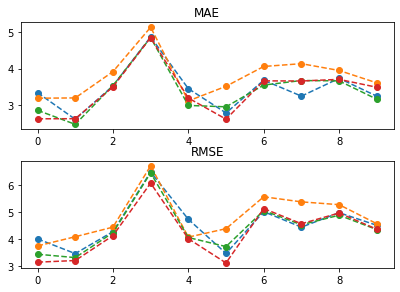

In [27]:
scaler = skpre.StandardScaler()

lr  = linear_model.LinearRegression()
knn_3 = neighbors.KNeighborsRegressor(n_neighbors=3)
knn_10 =  neighbors.KNeighborsRegressor(n_neighbors=10)

std_lr_pipe  = pipeline.make_pipeline(scaler, lr)
std_knn3_pipe  = pipeline.make_pipeline(scaler, knn_3)
std_knn10_pipe  = pipeline.make_pipeline(scaler, knn_10)

# 표준화와 관계 없이 평균은 항상 같아야 합니다.
regressors = {'baseline'  : dummy.DummyRegressor(strategy='mean'),
              'std_knn3'  : std_knn3_pipe,
              'std_knn10' : std_knn10_pipe,
              'std_lr'    : std_lr_pipe}

msrs = {'MAE'  : metrics.make_scorer(metrics.mean_absolute_error),
        'RMSE' : metrics.make_scorer(rms_error)}

fig, axes = plt.subplots(2, 1, figsize=(6,4))
fig.tight_layout()
for mod_name, model in regressors.items():
    cv_results = skms.cross_validate(model, 
                                     student_ftrs, student_tgt, 
                                     scoring = msrs, cv=10)

    for ax, msr in zip(axes, msrs):
        msr_results = cv_results["test_" + msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name, 
                                               msr_results.mean(), 
                                               msr_results.std())
        ax.plot(msr_results, 'o--', label=my_lbl)
        ax.set_title(msr)
#         ax.legend() # 범례를 표현하려면 주석을 해제하세요

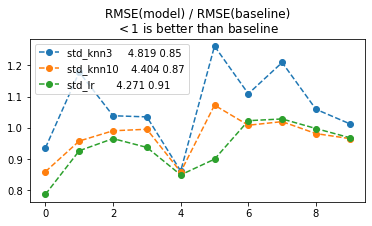

In [28]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
baseline_results = skms.cross_val_score(regressors['baseline'], 
                                        student_ftrs, student_tgt, 
                                        scoring = msrs['RMSE'], cv=10)

for mod_name, model in regressors.items():
    if mod_name.startswith("std_"):
        cv_results = skms.cross_val_score(model, 
                                          student_ftrs, student_tgt, 
                                          scoring = msrs['RMSE'], cv=10)

        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name, 
                                               cv_results.mean(), 
                                               cv_results.std())

        ax.plot(cv_results / baseline_results, 'o--', label=my_lbl)
ax.set_title("RMSE(model) / RMSE(baseline)\n$<1$ is better than baseline")
ax.legend();

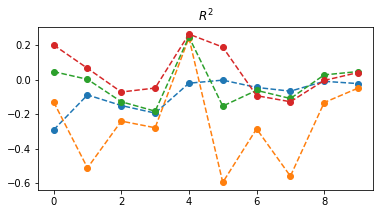

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
for mod_name, model in regressors.items():
        cv_results = skms.cross_val_score(model, 
                                          student_ftrs, student_tgt, 
                                          cv=10)
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name, 
                                               cv_results.mean(), 
                                               cv_results.std())

        ax.plot(cv_results, 'o--', label=my_lbl)
ax.set_title("$R^2$");
# ax.legend() # 범례를 표현하려면 주석을 해제하세요

In [30]:
msrs = {'MAD'  : metrics.mean_absolute_error,
        'RMSE' : rms_error}

results = {}
for mod_name, model in regressors.items():
    cv_preds = skms.cross_val_predict(model, 
                                      student_ftrs, student_tgt,
                                      cv=10)
    for ax, msr in zip(axes, msrs):
        msr_results = msrs[msr](student_tgt, cv_preds)
        results.setdefault(msr, []).append(msr_results)
df = pd.DataFrame(results, index=regressors.keys())
df

,MAD,RMSE
baseline,3.4470,4.6116
std_knn3,3.7797,4.8915
std_knn10,3.3666,4.4873
std_lr,3.3883,4.3653


,count,mean,std,min,25%,50%,75%,max
G3,395.0000,10.4152,4.5814,0.0000,8.0000,11.0000,14.0000,20.0000


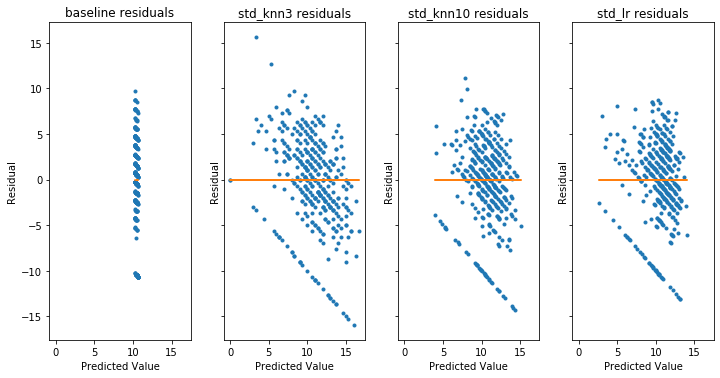

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(10,5), 
                         sharex=True, sharey=True)
fig.tight_layout()

for model_name, ax in zip(regressors, axes):
    model = regressors[model_name]
    preds = skms.cross_val_predict(model, 
                                   student_ftrs, student_tgt,
                                   cv=10)

    regression_residuals(ax, preds, student_tgt)
    ax.set_title(model_name + " residuals")
pd.DataFrame(student_tgt).describe().T